# Intro

## Links

Canvas: https://canvas.northwestern.edu/courses/167719/assignments/1078610?module_item_id=2319284




Kaggle: https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

## Modules

In [ ]:
#For data manipulation and visualization
from google.colab import files

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.pyplot import subplots_adjust
import seaborn as sns
import random


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, precision_score, recall_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn import cluster

from datetime import datetime

from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random

import tensorflow as tf
import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras import backend as K


import os, cv2, re, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import pathlib

# Disable warning
import warnings
warnings.filterwarnings('ignore')


# Data Ingestion

## Kaggle Upload

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 63 bytes


In [ ]:
%%capture
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

## Kaggle Data Prep

In [ ]:
!unzip 'dogs-vs-cats-redux-kernels-edition.zip'

Archive:  dogs-vs-cats-redux-kernels-edition.zip
  inflating: sample_submission.csv   
  inflating: test.zip                
  inflating: train.zip               


In [ ]:
!unzip /content/train.zip
!unzip /content/test.zip

Streaming output truncated to the last 5000 lines.
  inflating: test/5499.jpg           
  inflating: test/55.jpg             
  inflating: test/550.jpg            
  inflating: test/5500.jpg           
  inflating: test/5501.jpg           
  inflating: test/5502.jpg           
  inflating: test/5503.jpg           
  inflating: test/5504.jpg           
  inflating: test/5505.jpg           
  inflating: test/5506.jpg           
  inflating: test/5507.jpg           
  inflating: test/5508.jpg           
  inflating: test/5509.jpg           
  inflating: test/551.jpg            
  inflating: test/5510.jpg           
  inflating: test/5511.jpg           
  inflating: test/5512.jpg           
  inflating: test/5513.jpg           
  inflating: test/5514.jpg           
  inflating: test/5515.jpg           
  inflating: test/5516.jpg           
  inflating: test/5517.jpg           
  inflating: test/5518.jpg           
  inflating: test/5519.jpg           
  inflating: test/552.jpg            

### Writing Training Data into DF

In [ ]:
filenames = os.listdir('./train')
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [ ]:
df

,filename,category
0,dog.4388.jpg,1
1,dog.6069.jpg,1
2,cat.11136.jpg,0
3,dog.2509.jpg,1
4,cat.4006.jpg,0
...,...,...
24995,dog.8066.jpg,1
24996,cat.10191.jpg,0
24997,cat.11318.jpg,0
24998,dog.6821.jpg,1


# EDA

In [ ]:
df['category'] = df['category'].astype(str)
target_counts=df['category'].value_counts()
print("Number of dogs in the dataset:{}".format(target_counts['1']))
print("Number of cats in the dataset:{}".format(target_counts['0']))

Number of dogs in the dataset:12500
Number of cats in the dataset:12500


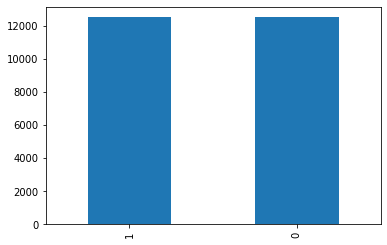

In [ ]:
df['category'].value_counts().plot.bar()

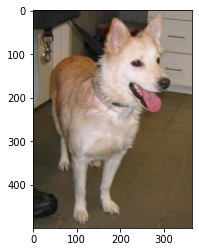

In [ ]:
# see sample image
sample = random.choice(filenames)
image = load_img("./train/"+sample)
plt.imshow(image)

In [ ]:
# import required module
from PIL import Image

img = image

# get width and height
width = img.width
height = img.height

# display width and height
print("The height of the image is: ", height)
print("The width of the image is: ", width)

The height of the image is:  500
The width of the image is:  365


# Prepare Data

In [ ]:
df.head()

,filename,category
0,dog.4388.jpg,1
1,dog.6069.jpg,1
2,cat.11136.jpg,0
3,dog.2509.jpg,1
4,cat.4006.jpg,0


In [ ]:
df['category'] = df['category'].astype(int)
df['category'] = df['category'].replace({0: 'cat', 1: 'dog'})
df.head()

,filename,category
0,dog.4388.jpg,dog
1,dog.6069.jpg,dog
2,cat.11136.jpg,cat
3,dog.2509.jpg,dog
4,cat.4006.jpg,cat


In [ ]:
df_sorted = df.sort_values(by=['category'])

In [ ]:
df_sorted

,filename,category
24999,cat.6520.jpg,cat
10331,cat.1438.jpg,cat
10333,cat.6862.jpg,cat
10334,cat.9003.jpg,cat
19755,cat.2312.jpg,cat
...,...,...
11020,dog.437.jpg,dog
11024,dog.9324.jpg,dog
11025,dog.3919.jpg,dog
11030,dog.9504.jpg,dog


## Create a subset

In [ ]:
df_cat = df_sorted.iloc[0:1300]
df_dog = df_sorted.iloc[12500:13800]

In [ ]:
frames = [df_cat, df_dog]

df_subset = pd.concat(frames)

df_subset

,filename,category
24999,cat.6520.jpg,cat
10331,cat.1438.jpg,cat
10333,cat.6862.jpg,cat
10334,cat.9003.jpg,cat
19755,cat.2312.jpg,cat
...,...,...
20881,dog.10042.jpg,dog
20882,dog.1725.jpg,dog
24333,dog.4327.jpg,dog
24807,dog.5097.jpg,dog


#Train-Test Splits

## Full Set

In [ ]:
X_full = df_sorted['filename']
Y_full = df_sorted['category']

In [ ]:
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, Y_full, test_size=0.20, random_state=42)

train_data = {'filename': X_train_full,
             'category': y_train_full}
train_full_df = pd.concat(train_data, axis=1)
train_full_df = train_full_df.reset_index(drop=True)

validate_full_data = {'filename': X_test_full,
             'category': y_test_full}
validate_full_df = pd.concat(validate_full_data, axis=1)
validate_full_df = validate_full_df.reset_index(drop=True)

## Subset

In [ ]:
X = df_subset['filename']
Y = df_subset['category']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

train_data = {'filename': X_train,
             'category': y_train}
train_df = pd.concat(train_data, axis=1)
train_df = train_df.reset_index(drop=True)

validate_data = {'filename': X_test,
             'category': y_test}
validate_df = pd.concat(validate_data, axis=1)
validate_df = validate_df.reset_index(drop=True)

In [ ]:
train_df

,filename,category
0,cat.3211.jpg,cat
1,cat.9948.jpg,cat
2,dog.6744.jpg,dog
3,cat.5102.jpg,cat
4,dog.3174.jpg,dog
...,...,...
2075,dog.4522.jpg,dog
2076,cat.7691.jpg,cat
2077,cat.10297.jpg,cat
2078,cat.8030.jpg,cat


In [ ]:
validate_df

,filename,category
0,dog.9433.jpg,dog
1,cat.9630.jpg,cat
2,cat.848.jpg,cat
3,dog.10043.jpg,dog
4,dog.7545.jpg,dog
...,...,...
515,dog.5407.jpg,dog
516,cat.9192.jpg,cat
517,cat.1030.jpg,cat
518,cat.4024.jpg,cat


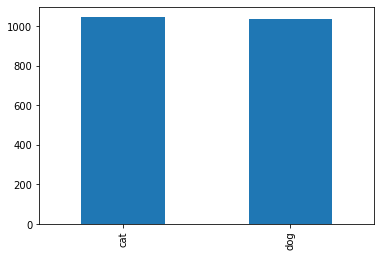

In [ ]:
train_df['category'].value_counts().plot.bar()

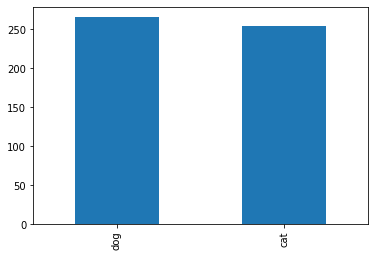

In [ ]:
validate_df['category'].value_counts().plot.bar()

# Prep Data for Models

## Define Constants

In [ ]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

## Training Generator

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "./train/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 2080 validated image filenames belonging to 2 classes.


## Validation Generator

In [ ]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "./train/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 520 validated image filenames belonging to 2 classes.


# Create CNN Models

## Model 1

In [ ]:
# model 1 hyperparameters
max_neurons = 64
max_dropout = 0.5
optimizer = 'rmsprop'

In [ ]:
model1 = Sequential()

model1.add(Conv2D(max_neurons/4, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(max_dropout/2))

model1.add(Conv2D(max_neurons/2, (3, 3), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(max_dropout/2))

model1.add(Conv2D(max_neurons, (3, 3), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(max_dropout/2))

model1.add(Flatten())
model1.add(Dense(max_neurons/2, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(max_dropout))
model1.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model1.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 32)       1

## Model 2

In [ ]:
# model 2 hyperparameters
max_neurons = 128
# max_dropout = 0.4
# optimizer = 'adam'

In [ ]:
model2 = Sequential()

model2.add(Conv2D(max_neurons/4, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(max_dropout/2))

model2.add(Conv2D(max_neurons/2, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(max_dropout/2))

model2.add(Conv2D(max_neurons, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(max_dropout/2))

model2.add(Flatten())
model2.add(Dense(max_neurons/2, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(max_dropout))
model2.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_4 (Batc  (None, 126, 126, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_5 (Batc  (None, 61, 61, 64)      

##Model 3

In [ ]:
# model 3 hyperparameters
max_neurons = 256
# max_dropout = 0.5
# optimizer = 'SGD'

In [ ]:
model3 = Sequential()

model3.add(Conv2D(max_neurons/4, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(max_dropout/2))

model3.add(Conv2D(max_neurons/2, (3, 3), activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(max_dropout/2))

model3.add(Conv2D(max_neurons, (3, 3), activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(max_dropout/2))

model3.add(Flatten())
model3.add(Dense(max_neurons/2, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(max_dropout))
model3.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model3.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 64)      1792      
                                                                 
 batch_normalization_8 (Batc  (None, 126, 126, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 63, 63, 64)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 63, 63, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 128)       73856     
                                                                 
 batch_normalization_9 (Batc  (None, 61, 61, 128)     

#Training/Testing Models

## Setting up callbacks

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# early stopping callback
earlystop = EarlyStopping(patience=10)

In [ ]:
# reduce the learning rate when the accuracy not increase for 2 steps
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [ ]:
callbacks = [earlystop, learning_rate_reduction]

## Model 1

In [ ]:
epochs=10

history = model1.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/10
138/138 [==============================] - 54s 376ms/step - loss: 0.9028 - accuracy: 0.5797 - val_loss: 2.8422 - val_accuracy: 0.5176 - lr: 0.0010
Epoch 2/10
138/138 [==============================] - 52s 375ms/step - loss: 0.7133 - accuracy: 0.6383 - val_loss: 0.8333 - val_accuracy: 0.4961 - lr: 0.0010
Epoch 3/10
138/138 [==============================] - ETA: 0s - loss: 0.6151 - accuracy: 0.6891
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
138/138 [==============================] - 51s 366ms/step - loss: 0.6151 - accuracy: 0.6891 - val_loss: 1.2736 - val_accuracy: 0.4902 - lr: 0.0010
Epoch 4/10
138/138 [==============================] - 50s 360ms/step - loss: 0.5337 - accuracy: 0.7395 - val_loss: 1.1516 - val_accuracy: 0.5471 - lr: 5.0000e-04
Epoch 5/10
138/138 [==============================] - 51s 369ms/step - loss: 0.4966 - accuracy: 0.7637 - val_loss: 1.0051 - val_accuracy: 0.5824 - lr: 5.0000e-04
Epoch 6/10
138/138 [=====================

In [ ]:
train_score = model1.evaluate_generator(train_generator, verbose=0)
print('Train loss:', train_score[0])
print('Train accuracy', train_score[1])

Train loss: 0.30284905433654785
Train accuracy 0.8879807591438293


In [ ]:
test_score = model1.evaluate_generator(validation_generator, verbose=0)
print('Test loss:', test_score[0])
print('Test accuracy', test_score[1])

Test loss: 0.7133089303970337
Test accuracy 0.7250000238418579


In [ ]:
results = pd.DataFrame(columns = ['Model', 'Max Neurons', 'Training Accuracy', 'Testing Accuracy'])

#eval
Model = 'Model 1'
Max_Neurons = 64
Training_Accuracy = train_score[1]
Testing_Accuracy = test_score[1]
row = [Model, Max_Neurons, Training_Accuracy, Testing_Accuracy]
results = results.append(pd.DataFrame([row], columns=results.columns), ignore_index=True)
results

,Model,Max Neurons,Training Accuracy,Testing Accuracy
0,Model 1,64,0.887981,0.725


## Model 2

In [ ]:
epochs=10

history = model2.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/10
138/138 [==============================] - 98s 696ms/step - loss: 0.9859 - accuracy: 0.5574 - val_loss: 0.9274 - val_accuracy: 0.4902 - lr: 0.0010
Epoch 2/10
138/138 [==============================] - 96s 694ms/step - loss: 0.8003 - accuracy: 0.6044 - val_loss: 2.2920 - val_accuracy: 0.4922 - lr: 0.0010
Epoch 3/10
138/138 [==============================] - 95s 690ms/step - loss: 0.6795 - accuracy: 0.6475 - val_loss: 0.8520 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 4/10
138/138 [==============================] - 96s 695ms/step - loss: 0.5689 - accuracy: 0.7094 - val_loss: 0.9780 - val_accuracy: 0.5569 - lr: 0.0010
Epoch 5/10
138/138 [==============================] - 96s 693ms/step - loss: 0.5121 - accuracy: 0.7404 - val_loss: 0.6510 - val_accuracy: 0.6608 - lr: 0.0010
Epoch 6/10
138/138 [==============================] - 96s 693ms/step - loss: 0.4720 - accuracy: 0.7860 - val_loss: 0.6867 - val_accuracy: 0.6353 - lr: 0.0010
Epoch 7/10
138/138 [==============================] 

In [ ]:
train_score = model2.evaluate_generator(train_generator, verbose=0)
print('Train loss:', train_score[0])
print('Train accuracy', train_score[1])

Train loss: 0.23876090347766876
Train accuracy 0.8942307829856873


In [ ]:
test_score = model2.evaluate_generator(validation_generator, verbose=0)
print('Test loss:', test_score[0])
print('Test accuracy', test_score[1])

Test loss: 0.7334896922111511
Test accuracy 0.6980769038200378


In [ ]:
#eval
Model = 'Model 2'
Max_Neurons = 128
Training_Accuracy = train_score[1]
Testing_Accuracy = test_score[1]
row = [Model, Max_Neurons, Training_Accuracy, Testing_Accuracy]
results = results.append(pd.DataFrame([row], columns=results.columns), ignore_index=True)
results

,Model,Max Neurons,Training Accuracy,Testing Accuracy
0,Model 1,64,0.887981,0.725000
1,Model 2,128,0.894231,0.698077


## Model 3

In [ ]:
epochs=10

history = model3.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/10
138/138 [==============================] - 247s 2s/step - loss: 1.0461 - accuracy: 0.5850 - val_loss: 0.7671 - val_accuracy: 0.5039 - lr: 0.0010
Epoch 2/10
138/138 [==============================] - 239s 2s/step - loss: 0.7859 - accuracy: 0.6276 - val_loss: 0.7832 - val_accuracy: 0.5235 - lr: 0.0010
Epoch 3/10
138/138 [==============================] - 239s 2s/step - loss: 0.6398 - accuracy: 0.6794 - val_loss: 0.8502 - val_accuracy: 0.5627 - lr: 0.0010
Epoch 4/10
138/138 [==============================] - 239s 2s/step - loss: 0.5510 - accuracy: 0.7346 - val_loss: 0.6776 - val_accuracy: 0.6471 - lr: 0.0010
Epoch 5/10
138/138 [==============================] - 236s 2s/step - loss: 0.4888 - accuracy: 0.7685 - val_loss: 0.6469 - val_accuracy: 0.6490 - lr: 0.0010
Epoch 6/10
138/138 [==============================] - 241s 2s/step - loss: 0.4228 - accuracy: 0.8058 - val_loss: 0.6747 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 7/10
138/138 [==============================] - 241s 2s/st

In [ ]:
train_score = model3.evaluate_generator(train_generator, verbose=0)
print('Train loss:', train_score[0])
print('Train accuracy', train_score[1])

Train loss: 0.1372830867767334
Train accuracy 0.9427884817123413


In [ ]:
test_score = model3.evaluate_generator(validation_generator, verbose=0)
print('Test loss:', test_score[0])
print('Test accuracy', test_score[1])

Test loss: 0.7556783556938171
Test accuracy 0.7230769395828247


In [ ]:
#eval
Model = 'Model 3'
Max_Neurons = 256
Training_Accuracy = train_score[1]
Testing_Accuracy = test_score[1]
row = [Model, Max_Neurons, Training_Accuracy, Testing_Accuracy]
results = results.append(pd.DataFrame([row], columns=results.columns), ignore_index=True)
results

,Model,Max Neurons,Training Accuracy,Testing Accuracy
0,Model 1,64,0.887981,0.725000
1,Model 2,128,0.894231,0.698077
2,Model 3,256,0.942788,0.723077


# ROC and Precision/Recall Graphs

In [ ]:
from sklearn.metrics import roc_curve,roc_auc_score, auc

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    validate_df,
    "./train/",
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 520 validated image filenames.


## ROC

In [ ]:
y_test = y_test.map({'dog': 1, 'cat': 0}).astype(int)

In [ ]:
y_pred1 = model1.predict_generator(test_generator)
y_pred1 = np.argmax(y_pred1, axis=-1)
y_pred1 = pd.DataFrame(y_pred1, columns = ['category'])
fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred1)

y_pred2 = model2.predict_generator(test_generator)
y_pred2 = np.argmax(y_pred2, axis=-1)
y_pred2 = pd.DataFrame(y_pred2, columns = ['category'])
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_pred2)

y_pred3 = model3.predict_generator(test_generator)
y_pred3 = np.argmax(y_pred3, axis=-1)
y_pred3 = pd.DataFrame(y_pred3, columns = ['category'])
fpr3, tpr3, thresholds3 = roc_curve(y_test, y_pred3)

In [ ]:
auc1 = auc(fpr1, tpr1)
auc2 = auc(fpr2, tpr2)
auc3 = auc(fpr3, tpr3)

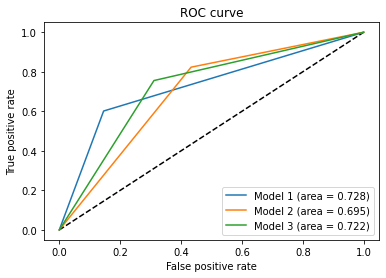

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr1, tpr1, label='Model 1 (area = {:.3f})'.format(auc1))
plt.plot(fpr2, tpr2, label='Model 2 (area = {:.3f})'.format(auc2))
plt.plot(fpr3, tpr3, label='Model 3 (area = {:.3f})'.format(auc3))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Precion Recall

In [ ]:
precision1, recall1, thresholds1 = precision_recall_curve(y_test, y_pred1)
precision2, recall2, thresholds2 = precision_recall_curve(y_test, y_pred2)
precision3, recall3, thresholds3 = precision_recall_curve(y_test, y_pred3)

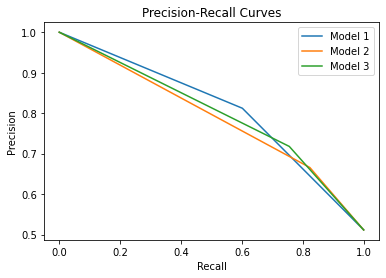

In [ ]:
plt.figure(1)
plt.plot(recall1, precision1, label='Model 1')
plt.plot(recall2, precision2, label='Model 2')
plt.plot(recall3, precision3, label='Model 3')
plt.title(f'Precision-Recall Curves')
plt.legend(loc='best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

#Training the Best Model w/ All Data

## Prep Data for Models

### Define Constants

In [ ]:
total_train = train_full_df.shape[0]
total_validate = validate_full_df.shape[0]
batch_size=15

IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [ ]:
# model 4 hyperparameters
max_neurons = 64
# max_dropout = 0.5
# optimizer = 'SGD'

In [ ]:
model4 = Sequential()

model4.add(Conv2D(max_neurons/4, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(max_dropout/2))

model4.add(Conv2D(max_neurons/2, (3, 3), activation='relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(max_dropout/2))

model4.add(Conv2D(max_neurons, (3, 3), activation='relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(max_dropout/2))

model4.add(Flatten())
model4.add(Dense(max_neurons/2, activation='relu'))
model4.add(BatchNormalization())
model4.add(Dropout(max_dropout))
model4.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model4.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 126, 126, 16)      448       
                                                                 
 batch_normalization_12 (Bat  (None, 126, 126, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 63, 63, 16)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 63, 63, 16)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 61, 61, 32)        4640      
                                                                 
 batch_normalization_13 (Bat  (None, 61, 61, 32)      

### Training Generator

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
)

train_generator_full = train_datagen.flow_from_dataframe(
    train_full_df,
    "./train/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


### Validation Generator

In [ ]:
validation_generator_full = validation_datagen.flow_from_dataframe(
    validate_full_df,
    "./train/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


##Train/Test the Model

In [ ]:
epochs=3

history = model4.fit(
    train_generator_full,
    epochs=epochs,
    validation_data=validation_generator_full,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/3
1333/1333 [==============================] - 515s 386ms/step - loss: 0.5099 - accuracy: 0.7529 - val_loss: 0.5376 - val_accuracy: 0.7449 - lr: 0.0010
Epoch 2/3
1333/1333 [==============================] - 503s 377ms/step - loss: 0.4583 - accuracy: 0.7914 - val_loss: 0.4632 - val_accuracy: 0.7784 - lr: 0.0010
Epoch 3/3
1333/1333 [==============================] - 510s 383ms/step - loss: 0.4238 - accuracy: 0.8100 - val_loss: 0.5042 - val_accuracy: 0.7439 - lr: 0.0010


In [ ]:
test_score_full = model4.evaluate_generator(validation_generator_full, verbose=0)
print('Test loss:', test_score_full[0])
print('Test accuracy', test_score_full[1])

Test loss: 0.504469633102417
Test accuracy 0.7437999844551086


In [ ]:
y_test_full = y_test_full.map({'dog': 1, 'cat': 0}).astype(int)

In [ ]:
y_pred_full = model4.predict_generator(validation_generator_full)
y_pred_full = np.argmax(y_pred_full, axis=-1)
y_pred_full = pd.DataFrame(y_pred_full, columns = ['category'])
fpr, tpr, thresholds = roc_curve(y_test_full, y_pred_full)

In [ ]:
auc = auc(fpr, tpr)

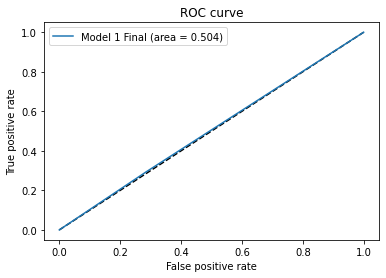

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Model 1 Final (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test_full, y_pred_full)

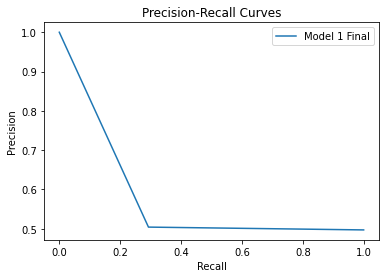

In [ ]:
plt.figure(1)
plt.plot(recall, precision, label='Model 1 Final')
plt.title(f'Precision-Recall Curves')
plt.legend(loc='best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# Predictions for Kaggle

## Prep test image data

In [ ]:
# prepare test data
test_filenames = os.listdir("./test/")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = len(test_df)

In [ ]:
# create testing image generator
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df,
    "./test/",
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=1,
    shuffle=False
)

Found 12500 validated image filenames.


## Model predictions

In [ ]:
predict = model4.predict_generator(test_generator, steps=nb_samples)

## Kaggle Submission

In [ ]:
# For categoral classication the prediction will come with probability of each category. So we will pick the category that have the highest probability with numpy average max
test_df['category'] = np.argmax(predict, axis=-1)

In [ ]:
# convert the predict category back into our generator classes
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [ ]:
# map the result back to dog is 1 and cat is 0
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

In [ ]:
# create Kaggle submission csv
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)

In [ ]:
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>